# Optimización de Estrategia Mean Reversion para $TSLA

Este notebook implementa la optimización de una estrategia de reversión a la media usando distintos algoritmos evolutivos como **PSO**, **algoritmos geneticos** y **TLBO**.

**Objetivo**: Encontrar los parámetros óptimos que maximicen el Ratio de Sharpe.

***¿Que es el ratio de Sharpe?***
Es una herramienta que mide la rentabilidad ajustada al riesgo. Calcula cuánto "retorno extra" está generando una inversión por encima de una inversión segura (libre de riesgo), por cada unidad de riesgo (volatilidad) asumida.

### Importar Librerias

In [139]:
import numpy as np
import pandas as pd
import yfinance as yf
import pyswarms as ps
from pyswarms.utils.plotters import plot_cost_history
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings

from deap import base, creator, tools, algorithms
import random

warnings.filterwarnings('ignore')

Ticker

In [140]:
ticker_input = 'TSLA'

### Descargar Datos de $TSLA (acciones de Tesla) desde ***yfinance***

In [141]:
def descargar_datos(data_from, data_to, ticker='TSLA'):
    """Descarga datos históricos de Yahoo Finance"""
    print(f" Descargando datos de {ticker}")
    try:
        data = yf.download(ticker, auto_adjust=True, progress=False, start=data_from, end=data_to)
        
        if isinstance(data.columns, pd.MultiIndex):
             try:
                 data = data.xs(ticker, level='Ticker', axis=1)
             except:
                 pass 

        if len(data) > 0:
            print(f" Datos descargados: {len(data)} dias")
            print(f"    Rango: {data.index[0].date()} a {data.index[-1].date()}")
             
            precio_ini = data['Close'].iloc[0]
            precio_fin = data['Close'].iloc[-1]
            
            if hasattr(precio_ini, 'item'): 
                precio_ini = precio_ini.item()
                precio_fin = precio_fin.item()

            print(f"    Precio: ${precio_ini:.2f} → ${precio_fin:.2f}")
            return data
            
    except Exception as e:
        print(f" Error: {e}")
        return None

datos = descargar_datos('2025-03-01', '2025-12-10', ticker = ticker_input)

if datos is not None:
    print(datos.head())

 Descargando datos de TSLA
 Datos descargados: 196 dias
    Rango: 2025-03-03 a 2025-12-09
    Precio: $284.65 → $445.17
Price            Close        High         Low        Open     Volume
Date                                                                 
2025-03-03  284.649994  303.940002  277.299988  300.339996  115551400
2025-03-04  272.040009  284.350006  261.839996  270.929993  126706600
2025-03-05  279.100006  279.549988  267.709991  272.920013   94042900
2025-03-06  263.450012  272.649994  260.019989  272.059998   98451600
2025-03-07  262.670013  266.250000  250.729996  259.320007  102369600


###  Definir Estrategia de Trading

In [142]:
def calcular_rsi(precios, periodo=14):
    """Calcula el relative strength index (RSI)"""
    delta = precios.diff()
    ganancia = delta.where(delta > 0, 0)
    perdida = -delta.where(delta < 0, 0)
    
    avg_ganancia = ganancia.rolling(window=periodo, min_periods=1).mean()
    avg_perdida = perdida.rolling(window=periodo, min_periods=1).mean()
    
    rs = avg_ganancia / avg_perdida
    rsi = 100 - (100 / (1 + rs))
    return rsi

def backtest_estrategia(data, periodo_rsi, umbral_compra, umbral_venta, stop_loss_pct):
    """ejecuta backtest de la estrategia de mean reversion"""
    df = data.copy()
    df['RSI'] = calcular_rsi(df['Close'], periodo=int(periodo_rsi))
    
    posicion = 0
    precio_entrada = 0
    capital = 10000
    trades = []
    
    for i in range(len(df)):
        precio_actual = df['Close'].iloc[i]
        rsi_actual = df['RSI'].iloc[i]
        
        if np.isnan(rsi_actual):
            continue
        
        # Señal de compra
        if posicion == 0 and rsi_actual < umbral_compra:
            posicion = 1
            precio_entrada = precio_actual
            cantidad = capital / precio_actual
            
        # Señal de venta
        elif posicion == 1:
            if rsi_actual > umbral_venta:
                capital = cantidad * precio_actual
                retorno = (precio_actual - precio_entrada) / precio_entrada
                trades.append(retorno)
                posicion = 0
            elif (precio_entrada - precio_actual) / precio_entrada >= stop_loss_pct / 100:
                capital = cantidad * precio_actual
                retorno = (precio_actual - precio_entrada) / precio_entrada
                trades.append(retorno)
                posicion = 0
    
    if posicion == 1:
        capital = cantidad * df['Close'].iloc[-1]
        retorno = (df['Close'].iloc[-1] - precio_entrada) / precio_entrada
        trades.append(retorno)
    
    if len(trades) == 0:
        return -10
    
    retornos = np.array(trades)
    volatilidad = np.std(retornos)
    
    if volatilidad == 0 or np.isnan(volatilidad):
        return -10
    
    sharpe_ratio = (np.mean(retornos) / volatilidad) * np.sqrt(252)
    
    
    return sharpe_ratio

# prueba
sharpe_ejemplo = backtest_estrategia(datos, 14, 30, 70, 5)
print(f"\n Sharpe Ratio con parametros por defecto (RSI=14, Compra=30, Venta=70, SL=5%): {sharpe_ejemplo:.4f}")


 Sharpe Ratio con parametros por defecto (RSI=14, Compra=30, Venta=70, SL=5%): 10.0205


---
##  Algoritmo 1: Optimizacion por enjambre de particulas (PSO)

Este es el nucleo del algoritmo donde se ejecutan los 5 pasos:
1. **Inicialización**: Crear enjambre de partículas
2. **Evaluación**: Calcular fitness (Sharpe Ratio) de cada partícula
3. **Comunicación**: Compartir pbest y gbest
4. **Movimiento**: Actualizar velocidades y posiciones
5. **Iteración**: Repetir hasta convergencia

Configurar primero PSO

In [143]:
# Variable global para pasar datos al optimizador
datos_globales = None

def funcion_objetivo(particulas):
    """Función objetivo para PSO"""
    n_particulas = particulas.shape[0]
    fitness = np.zeros(n_particulas)
    
    for i in range(n_particulas):
        periodo_rsi = particulas[i, 0]
        umbral_compra = particulas[i, 1]
        umbral_venta = particulas[i, 2]
        stop_loss = particulas[i, 3]
        
        if umbral_compra >= umbral_venta:
            fitness[i] = 1000
            continue
        
        sharpe = backtest_estrategia(datos_globales, periodo_rsi, 
                                     umbral_compra, umbral_venta, stop_loss)
        fitness[i] = -sharpe
    
    return fitness

print(" Función objetivo configurada")

 Función objetivo configurada


In [144]:
datos_globales = datos

# configuracion PSO
n_particulas = 30
n_iteraciones = 50

# limites de busqueda
limites_min = np.array([5, 10, 60, 1])    # [periodo_rsi, umbral_compra, umbral_venta, stop_loss]
limites_max = np.array([50, 40, 90, 10])
bounds = (limites_min, limites_max)

# Parámetros PSO
options = {
    'c1': 2.0,  # Cognitivo
    'c2': 2.0,  # Social
    'w': 0.9    # Inercia
}

print("="*70)
print(" Inicia la optimizacion PSO")
print("="*70)
print(f"Particulas: {n_particulas}")
print(f"Iteraciones: {n_iteraciones}")
print(f"Evaluaciones totales: {n_particulas * n_iteraciones}")
print("\nEjecutando:\n")

# crear optimizador
optimizer = ps.single.GlobalBestPSO(
    n_particles=n_particulas,
    dimensions=4,
    options=options,
    bounds=bounds
)

# optimizar
mejor_costo, mejor_posicion = optimizer.optimize(
    funcion_objetivo,
    iters=n_iteraciones,
    verbose=True
)

mejor_sharpe = -mejor_costo

print("\n" + "="*70)
print(" Optimizacion completa")
print("="*70)
print(f"\n Parametros optimos:")
print(f"   Periodo RSI:     {mejor_posicion[0]:.1f}")
print(f"   Umbral compra:   {mejor_posicion[1]:.1f}")
print(f"   Umbral venta:    {mejor_posicion[2]:.1f}")
print(f"   Stop loss:       {mejor_posicion[3]:.1f}%")
print(f"\n Sharpe Ratio Maximo: {mejor_sharpe:.4f}")

2025-12-15 23:51:37,074 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2.0, 'c2': 2.0, 'w': 0.9}


 Inicia la optimizacion PSO
Particulas: 30
Iteraciones: 50
Evaluaciones totales: 1500

Ejecutando:



pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████████|50/50, best_cost=-21.5
2025-12-15 23:51:44,876 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -21.5377778958155, best pos: [ 7.02246465 12.80816103 66.83746716  2.91205623]



 Optimizacion completa

 Parametros optimos:
   Periodo RSI:     7.0
   Umbral compra:   12.8
   Umbral venta:    66.8
   Stop loss:       2.9%

 Sharpe Ratio Maximo: 21.5378


### Visualizar Convergencia

<Figure size 1000x600 with 0 Axes>

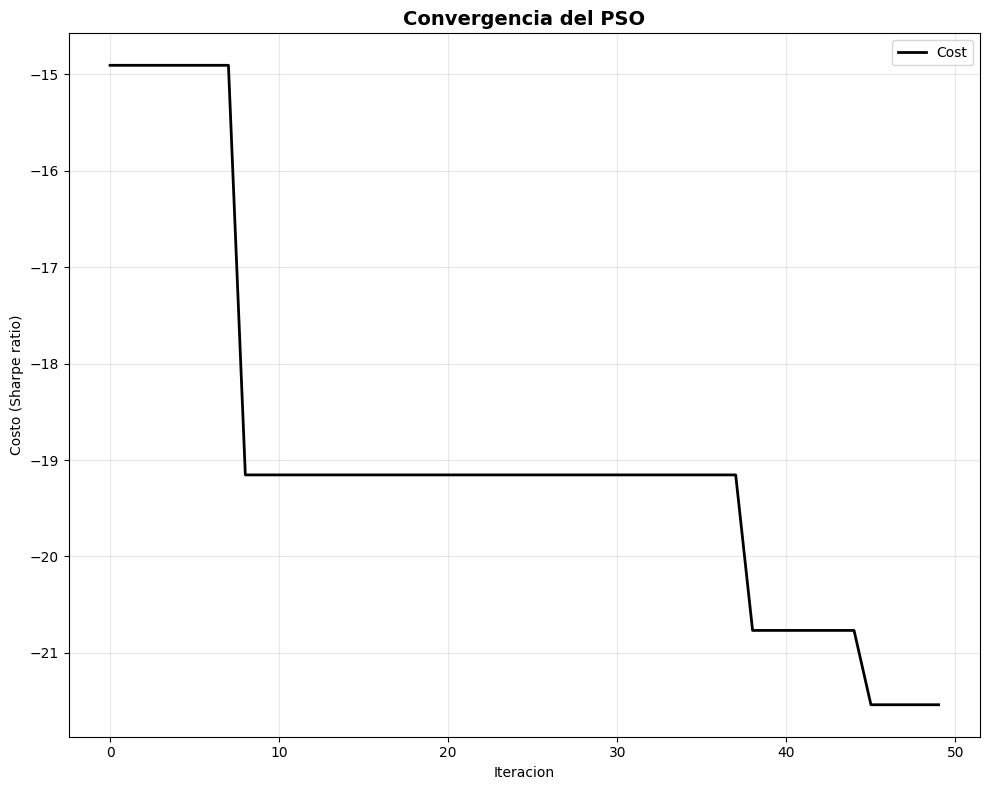

In [145]:
plt.figure(figsize=(10, 6))
plot_cost_history(cost_history=optimizer.cost_history)
plt.title('Convergencia del PSO', fontsize=14, fontweight='bold')
plt.xlabel('Iteracion')
plt.ylabel('Costo (Sharpe ratio)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Conclusiones:**
1. El algoritmo funciona: La curva va hacia abajo, lo cual es correcto. Dado que la función objetivo devuelve fitness[i] = -sharpe, el gráfico muestra que el Costo ha bajado de aproximadamente -15 a -21. Esto significa que el algoritmo logró aumentar el Sharpe Ratio de tu estrategia desde 15 hasta 21.
2. Comportamiento de "Escalones" : La forma de la línea es muy característica de los algoritmos de enjambre y evolutivos, una serie de líneas planas seguidas de caídas abruptas. Durante las líneas planas, el enjambre estaba "atrapado" en un mínimo local. Las partículas daban vueltas alrededor de una solución buena, pero no encontraban nada mejor. Las caídas -las bajadas verticales- ocurren cuando una partícula "exploradora" encuentra una nueva zona mejor y todo el enjambre se mueve rápidamente hacia esa nueva posición (el Global Best se actualiza).
3. Convergencia tardía: Es notable el salto cerca de la iteración 50. Esto indica que 50 iteraciones fueron necesarias. Si se hubiera cortado la optimización en la iteración 30, se habría perdido una mejora significativa (pasando de un costo de -19 a -22). El algoritmo aún tenía capacidad de exploración avanzada la partida.

----
## Algoritmo 2: Optimizacion genetica (biblioteca DEAP)

In [132]:
# Objetivo: maximizar el sharpe ratio (peso positivo 1.0)
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

def random_params():
    return [
        random.uniform(5, 30),   # periodo_rsi (5 a 30)
        random.uniform(10, 45),  # umbral_compra (10 a 45)
        random.uniform(55, 90),  # umbral_venta (55 a 90)
        random.uniform(0.01, 0.15) # stop_loss_pct (1% a 15%)
    ]

# registro la creacion de individuos y poblacion
toolbox.register("attr_float", random_params)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# funcion de evaluacion
def evaluar_individuo(individual):
    periodo_rsi = int(round(individual[0]))
    umbral_compra = int(round(individual[1]))
    umbral_venta = int(round(individual[2]))
    stop_loss = individual[3] # Este se queda como float
    
    # si la compra es mayor a la venta o el periodo es absurdo, castigo severamente
    if umbral_compra >= umbral_venta or periodo_rsi < 2:
        return (-999.0,) # Sharpe muy negativo
    
    # ejecutar backtest
    sharpe = backtest_estrategia(datos_globales, periodo_rsi, umbral_compra, umbral_venta, stop_loss)
    
    return (sharpe,)

# operadores geneticos 
toolbox.register("evaluate", evaluar_individuo)

# seleccion por torneo (tournament size = 5)
toolbox.register("select", tools.selTournament, tournsize=5)

# cruce uniforme (indpb es la prob. de intercambiar cada atributo)
toolbox.register("mate", tools.cxUniform, indpb=0.5)

# mutacion Gaussiana
mu_list = [0, 0, 0, 0]
sigma_list = [2.0, 5.0, 5.0, 0.02] # el RSI muta +/- 2, el SL muta +/- 0.02
toolbox.register("mutate", tools.mutGaussian, mu=mu_list, sigma=sigma_list, indpb=0.2)

# limitar limites
# La mutación gaussiana puede sacar los valores de rango (ej: RSI -5). 
# Esta función fuerza los limites.
def checkBounds(min_vals, max_vals):
    def decorator(func):
        def wrapper(*args, **kargs):
            offspring = func(*args, **kargs)
            for child in offspring:
                for i in range(len(child)):
                    if child[i] < min_vals[i]:
                        child[i] = min_vals[i]
                    elif child[i] > max_vals[i]:
                        child[i] = max_vals[i]
            return offspring
        return wrapper
    return decorator

MIN_BOUNDS = [2, 1, 1, 0.001]
MAX_BOUNDS = [100, 99, 99, 0.5]

toolbox.decorate("mate", checkBounds(MIN_BOUNDS, MAX_BOUNDS))
toolbox.decorate("mutate", checkBounds(MIN_BOUNDS, MAX_BOUNDS))

gen	nevals	avg     	max    
0  	50    	-6.34874	21.5378
1  	33    	5.09548 	21.5378
2  	43    	14.177  	21.5378
3  	45    	19.7731 	21.5378
4  	43    	19.784  	21.5378
5  	36    	20.8965 	21.5378
6  	40    	21.1309 	21.5378
7  	44    	20.2903 	21.5378
8  	40    	21.2713 	21.5378
9  	39    	20.5131 	21.5378
10 	34    	20.9759 	21.5378
11 	41    	20.1713 	21.5378
12 	42    	20.9861 	21.5378
13 	38    	19.3776 	21.5378
14 	40    	19.361  	21.5378
15 	44    	20.6995 	21.5378
16 	43    	20.107  	21.5378
17 	37    	20.1344 	21.5378
18 	43    	20.0029 	21.5378
19 	43    	19.8694 	21.5378
20 	35    	19.6422 	21.5378


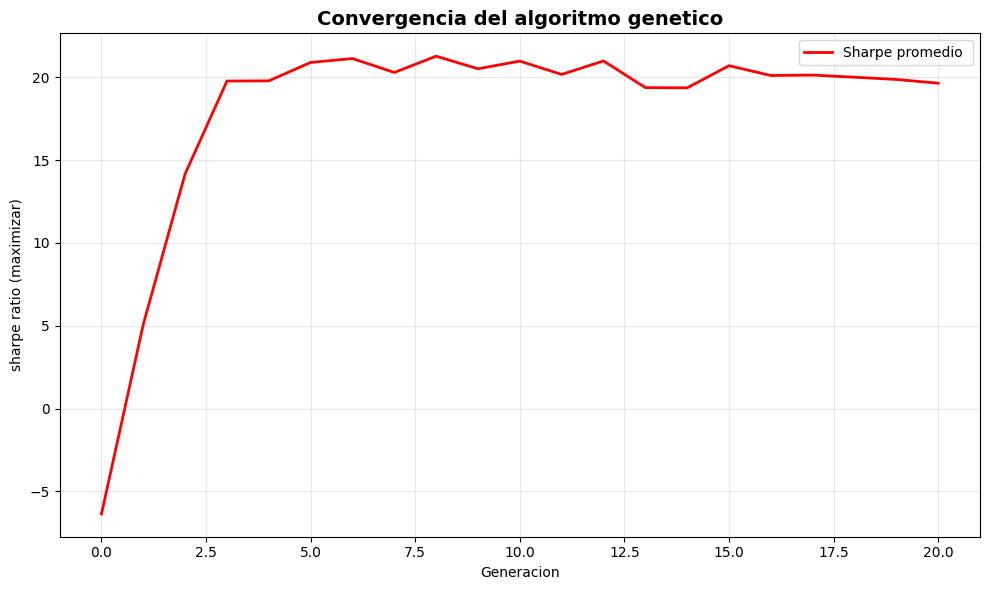


 Optimizacion finalizada 
Mejor sharpe ratio: 21.5378
Parametros optimos:
  Periodo RSI:   7
  Umbral compra: 12
  Umbral venta:  59
  Stop loss %:   0.0978


In [133]:
random.seed(42) # reproducibilidad
    
# Parametros del GA
N_POP = 50        # tamaño de poblacion
N_GEN = 20        # numero de generaciones
CXPB = 0.7        # probabilidad de cruce
MUTPB = 0.3       # probabilidad de mutacion
    
pop = toolbox.population(n=N_POP)
    
# hall of fame (guarda el mejor historico)
hof = tools.HallOfFame(1)
    
# Estadisticas para monitorear
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("max", np.max)
    
# algoritmo eaSimple 
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, 
                                   ngen=N_GEN, stats=stats, halloffame=hof, 
                                   verbose=True)
    
# logbook
generaciones = log.select("gen")
fit_max = log.select("max")  # mejor sharpe de cada generacion
fit_avg = log.select("avg")  # promedio de la poblacion
    
plt.figure(figsize=(10, 6))
    
# grafico el mejor caso 
plt.plot(generaciones, fit_avg, label='Sharpe promedio ', color='red', linewidth=2)
plt.title('Convergencia del algoritmo genetico', fontsize=14, fontweight='bold')
plt.xlabel('Generacion')
plt.ylabel('sharpe ratio (maximizar)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
    
print("\n Optimizacion finalizada ")
best_ind = hof[0]
print(f"Mejor sharpe ratio: {best_ind.fitness.values[0]:.4f}")
print("Parametros optimos:")
print(f"  Periodo RSI:   {int(round(best_ind[0]))}")
print(f"  Umbral compra: {int(round(best_ind[1]))}")
print(f"  Umbral venta:  {int(round(best_ind[2]))}")
print(f"  Stop loss %:   {best_ind[3]:.4f}")

---
## Algoritmo 3: Optimizacion por colonia de hormigas

Inicio de la optimizacion TLBO
Gen 0: Mejor Sharpe = 12.0344
Gen 5: Mejor Sharpe = 21.5378
Gen 10: Mejor Sharpe = 21.5378
Gen 15: Mejor Sharpe = 21.5378
Gen 20: Mejor Sharpe = 21.5378
Gen 25: Mejor Sharpe = 21.5378
Gen 30: Mejor Sharpe = 21.5378
Gen 35: Mejor Sharpe = 21.5378
Gen 40: Mejor Sharpe = 21.5378
Gen 45: Mejor Sharpe = 21.5378

--- Resultado TLBO ---
Mejor Sharpe Global: 21.5378
RSI: 7
Compra: 10
Venta: 61
Stop Loss: 0.0806


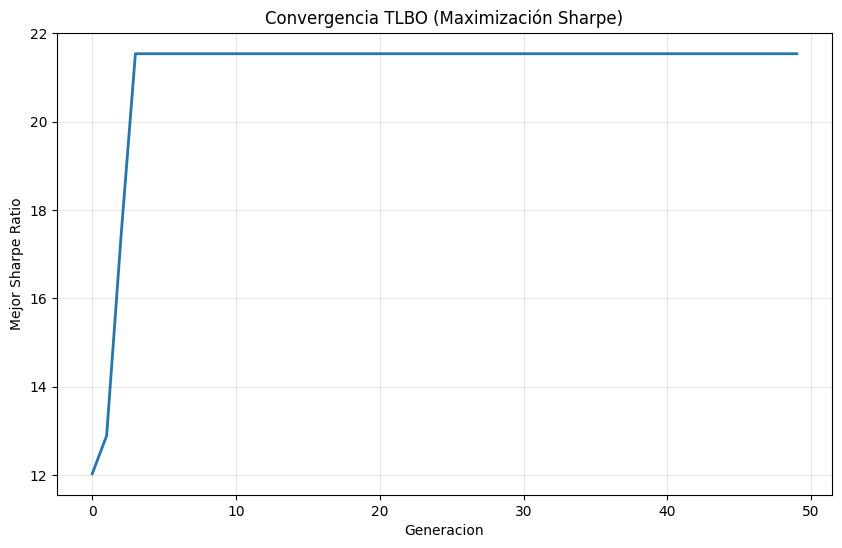

In [134]:
# --- Clase TLBO ---
class TLBOOptimizer:
    def __init__(self, func_objetivo, data, bounds, n_pop=50, n_gen=20):
        """
        Args:
            func_objetivo: La funcion a optimizar (backtest_estrategia).
            data: Los datos globales (df) que necesita la funcion.
            bounds: Limites de los parametros.
            n_pop: Tamaño de la poblacion.
            n_gen: Numero de generaciones.
        """
        self.func = func_objetivo
        self.data = data 
        self.bounds = np.array(bounds)
        self.n_pop = n_pop
        self.n_gen = n_gen
        self.dim = len(bounds)
        
        # Inicializar poblacion aleatoria
        self.pop = np.zeros((n_pop, self.dim))
        for i in range(self.dim):
            low, high = self.bounds[i]
            self.pop[:, i] = np.random.uniform(low, high, n_pop)
            
        self.fitness = np.zeros(n_pop)
        self.best_score = -np.inf
        self.best_ind = None
        self.history = []

    def _evaluar(self, individuo):
        # Casteo de enteros para RSI y Umbrales
        p_rsi = int(round(individuo[0]))
        u_compra = int(round(individuo[1]))
        u_venta = int(round(individuo[2]))
        sl = individuo[3]
        
        # restricciones Logicas 
        if u_compra >= u_venta or p_rsi < 2:
            return -999.0 # Penalización fuerte
        
        return self.func(self.data, p_rsi, u_compra, u_venta, sl)

    def _clip(self, individuo):
        """Mantiene los valores dentro de los límites"""
        for i in range(self.dim):
            low, high = self.bounds[i]
            individuo[i] = np.clip(individuo[i], low, high)
        return individuo

    def optimize(self):
        # Evaluacion inicial
        for i in range(self.n_pop):
            self.fitness[i] = self._evaluar(self.pop[i])
        
        # loop de generaciones
        for gen in range(self.n_gen):
            
            # identificar al profesor -mejor fitness-
            idx_best = np.argmax(self.fitness)
            teacher = self.pop[idx_best].copy()
            
            # guardar historico para el grafico
            current_best_score = self.fitness[idx_best]
            if current_best_score > self.best_score:
                self.best_score = current_best_score
                self.best_ind = teacher.copy()
            self.history.append(self.best_score)
            
            # imprimir progreso cada 5 generaciones 
            if gen % 5 == 0:
                print(f"Gen {gen}: Mejor Sharpe = {self.best_score:.4f}")

            # promedio de la clase actual
            mean_pop = np.mean(self.pop, axis=0)

            for i in range(self.n_pop):
                # fase docente
                tf = random.choice([1, 2])
                r = np.random.rand(self.dim)
                
                diff = r * (teacher - tf * mean_pop)
                
                new_sol = self.pop[i] + diff
                new_sol = self._clip(new_sol)
                new_fitness = self._evaluar(new_sol)
                
                if new_fitness > self.fitness[i]:
                    self.pop[i] = new_sol
                    self.fitness[i] = new_fitness

                # Fase alumno
                idxs = list(range(self.n_pop))
                idxs.remove(i)
                j = random.choice(idxs)
                
                partner = self.pop[j]
                r = np.random.rand(self.dim)
                
                # dirección basada en el mejor
                if self.fitness[i] > self.fitness[j]:
                    step = self.pop[i] - partner
                else:
                    step = partner - self.pop[i]
                
                new_sol = self.pop[i] + r * step
                new_sol = self._clip(new_sol)
                new_fitness = self._evaluar(new_sol)
                
                if new_fitness > self.fitness[i]:
                    self.pop[i] = new_sol
                    self.fitness[i] = new_fitness

        return self.best_ind, self.best_score

# inicio
datos_globales = datos 
    
# Limites: [RSI, Compra, Venta, SL]
LIMITES = [
        [5, 30],    # RSI
        [10, 45],   # Compra
        [55, 90],   # Venta
        [0.01, 0.15] # Stop Loss
    ]

print("Inicio de la optimizacion TLBO")

optimizer = TLBOOptimizer(
        func_objetivo=backtest_estrategia, 
        data=datos_globales,               
        bounds=LIMITES, 
        n_pop=30,   
        n_gen=50    
)

mejores_params, mejor_sharpe = optimizer.optimize()

print("\n--- Resultado TLBO ---")
print(f"Mejor Sharpe Global: {mejor_sharpe:.4f}")
print(f"RSI: {int(round(mejores_params[0]))}")
print(f"Compra: {int(round(mejores_params[1]))}")
print(f"Venta: {int(round(mejores_params[2]))}")
print(f"Stop Loss: {mejores_params[3]:.4f}")
    
# graficar convergencia
plt.figure(figsize=(10, 6))
plt.plot(optimizer.history, linewidth=2)
plt.title("Convergencia TLBO (Maximización Sharpe)")
plt.xlabel("Generacion")
plt.ylabel("Mejor Sharpe Ratio")
plt.grid(True, alpha=0.3)
plt.show()

---
## Validar estrategia optimizada por PSO:

In [135]:
def validar_estrategia_detallada(data, params):
    """ valida la estrategia con analisis detallado"""
    periodo_rsi = int(params[0])
    umbral_compra = params[1]
    umbral_venta = params[2]
    stop_loss = params[3]
    
    df = data.copy()
    df['RSI'] = calcular_rsi(df['Close'], periodo=periodo_rsi)
    
    posicion = 0
    precio_entrada = 0
    capital = 10000
    historial_capital = [capital]
    trades = []
    
    for i in range(len(df)):
        precio_actual = df['Close'].iloc[i]
        rsi_actual = df['RSI'].iloc[i]
        
        if np.isnan(rsi_actual):
            historial_capital.append(historial_capital[-1])
            continue
        
        if posicion == 0 and rsi_actual < umbral_compra:
            posicion = 1
            precio_entrada = precio_actual
            cantidad = capital / precio_actual
            
        elif posicion == 1:
            if rsi_actual > umbral_venta or (precio_entrada - precio_actual) / precio_entrada >= stop_loss / 100:
                capital = cantidad * precio_actual
                retorno = (precio_actual - precio_entrada) / precio_entrada
                trades.append(retorno)
                posicion = 0
        
        historial_capital.append(capital if posicion == 0 else cantidad * precio_actual)
    
    if posicion == 1:
        capital = cantidad * df['Close'].iloc[-1]
    
    retornos = np.array(trades)
    retorno_total = (capital - 10000) / 10000 * 100
    
    print("\n" + "="*70)
    print(" Resultados del bakctest")
    print("="*70)
    print(f"Capital Inicial:      ${10000:,.2f}")
    print(f"Capital Final:        ${capital:,.2f}")
    print(f"Retorno Total:        {retorno_total:.2f}%")
    print(f"Número de Trades:     {len(trades)}")
    
    if len(trades) > 0:
        ganadores = retornos[retornos > 0]
        perdedores = retornos[retornos < 0]
        print(f"Trades Ganadores:     {len(ganadores)} ({len(ganadores)/len(trades)*100:.1f}%)")
        print(f"Trades Perdedores:    {len(perdedores)} ({len(perdedores)/len(trades)*100:.1f}%)")
        if len(ganadores) > 0:
            print(f"Ganancia Promedio:    {np.mean(ganadores)*100:.2f}%")
        if len(perdedores) > 0:
            print(f"Pérdida Promedio:     {np.mean(perdedores)*100:.2f}%")
    
    return df, historial_capital

In [136]:
df_estrategia, historial_capital = validar_estrategia_detallada(datos, mejor_posicion)


 Resultados del bakctest
Capital Inicial:      $10,000.00
Capital Final:        $21,138.26
Retorno Total:        111.38%
Número de Trades:     6
Trades Ganadores:     5 (83.3%)
Trades Perdedores:    1 (16.7%)
Ganancia Promedio:    17.16%
Pérdida Promedio:     -3.44%


## Visualizar resultados

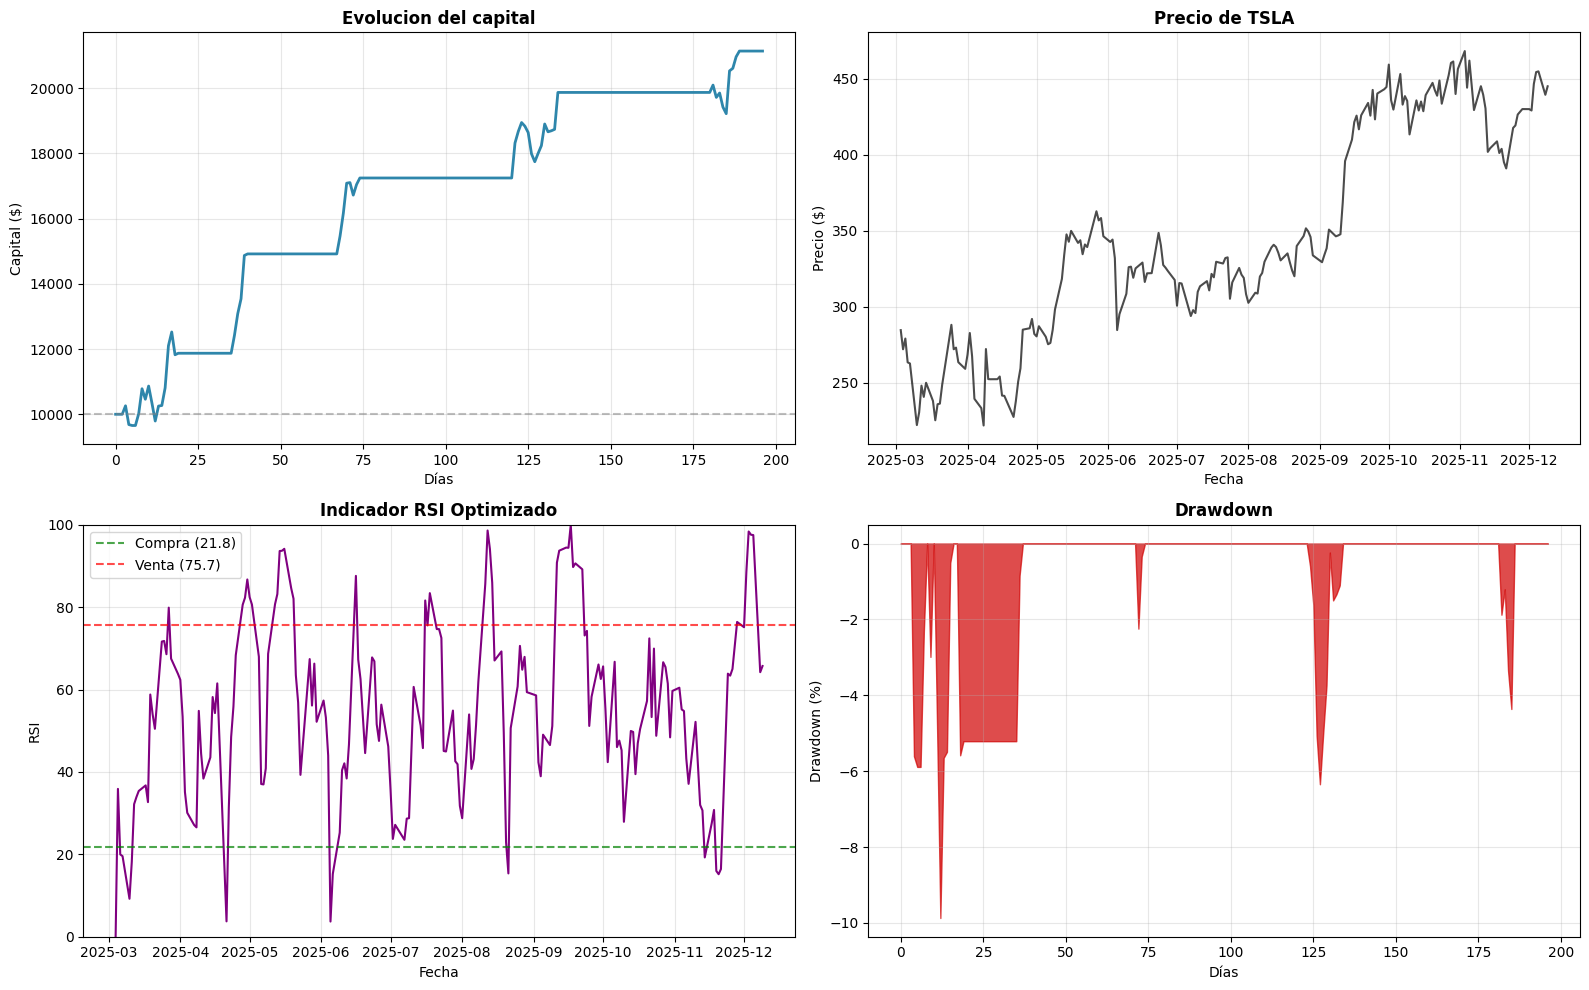

In [137]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Evolucion del capital
axes[0, 0].plot(historial_capital, linewidth=2, color='#2E86AB')
axes[0, 0].set_title('Evolucion del capital', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Días')
axes[0, 0].set_ylabel('Capital ($)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(y=10000, color='gray', linestyle='--', alpha=0.5)

# Precio
axes[0, 1].plot(datos.index, datos['Close'], linewidth=1.5, color='black', alpha=0.7)
axes[0, 1].set_title(f'Precio de {ticker_input}', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Fecha')
axes[0, 1].set_ylabel('Precio ($)')
axes[0, 1].grid(True, alpha=0.3)

# RSI
axes[1, 0].plot(df_estrategia.index, df_estrategia['RSI'], linewidth=1.5, color='purple')
axes[1, 0].axhline(y=mejor_posicion[1], color='green', linestyle='--', alpha=0.7, label=f'Compra ({mejor_posicion[1]:.1f})')
axes[1, 0].axhline(y=mejor_posicion[2], color='red', linestyle='--', alpha=0.7, label=f'Venta ({mejor_posicion[2]:.1f})')
axes[1, 0].set_title('Indicador RSI Optimizado', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Fecha')
axes[1, 0].set_ylabel('RSI')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim(0, 100)

# Drawdown
capital_serie = pd.Series(historial_capital)
drawdown = (capital_serie - capital_serie.cummax()) / capital_serie.cummax() * 100
axes[1, 1].fill_between(range(len(drawdown)), 0, drawdown, alpha=0.7, color='#D00000')
axes[1, 1].set_title('Drawdown', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Días')
axes[1, 1].set_ylabel('Drawdown (%)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Validar resultados con parametros obtenidos del algoritmo genetico:

In [138]:
df_estrategia, historial_capital = validar_estrategia_detallada(datos, np.array([7,12,59,0.0978]))


 Resultados del bakctest
Capital Inicial:      $10,000.00
Capital Final:        $17,572.76
Retorno Total:        75.73%
Número de Trades:     4
Trades Ganadores:     3 (75.0%)
Trades Perdedores:    1 (25.0%)
Ganancia Promedio:    22.06%
Pérdida Promedio:     -3.16%


Los resultados son muy similares a los obtenidos bajo los parametros originados con PSO.

---
## Conclusiones: